In [179]:
import os

from google.colab import drive
drive.mount('/content/gdrive')

os.chdir('/content/gdrive/MyDrive/first_try_of_fastai')

print("------------------------------------------------------------------")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
------------------------------------------------------------------


In [ ]:
#export
import os
os.chdir('/content/gdrive/MyDrive/first_try_of_fastai/exp')
from nb_05b import *
os.chdir('/content/gdrive/MyDrive/first_try_of_fastai')

**ConvNet**

In [ ]:
x_train, y_train, x_valid, y_valid = get_data()

In [ ]:
#export
def normalize_to(train, valid):
  m, s = train.mean(), train.std()
  return normalize(train, m, s), normalize(valid, m, s)

In [ ]:
x_train, x_valid = normalize_to(x_train, x_valid)
train_ds,valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [ ]:
x_train.mean(),x_train.std()

In [ ]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [ ]:
#eport
class Lambda(nn.Module):
  def __init__(self, func):
    super().__init__()
    self.func = func

  def forward(self, x): return self.func(x)

def flatten(x): return x.view(x.shape[0], -1)

In [ ]:
def mnist_resize(x): return x.view(-1,1,28,28)

In [ ]:
def get_cnn_model(data):
  return nn.Sequential(
      Lambda(mnist_resize),
      nn.Conv2d( 1, 8,5, padding=2, stride=2), nn.ReLU(),
      nn.Conv2d( 8,16,3, padding=1, stride=2), nn.ReLU(),
      nn.Conv2d(16,32,3, padding=1, stride=2), nn.ReLU(),
      nn.Conv2d(32,32,3, padding=1, stride=2), nn.ReLU(),
      nn.AdaptiveAvgPool2d(1),
      Lambda(flatten),
      nn.Linear(32, data.c)
  )

In [ ]:
model = get_cnn_model(data)

In [ ]:
#Copy this to any notebook complaining about recorder or statscallbacks
class AvgStats():
  def __init__(self, metrics, in_train):
    self.metrics = listify(metrics)
    self.in_train = in_train
    self.tot_loss = 0.
    self.count=0
    self.tot_mets = [0.] * len(self.metrics)

  def reset(self):
    self.tot_loss, self.count = 0.,0
    self.tot_mets = [0.] * len(self.metrics)
  
  @property
  def all_stats(self): return[self.tot_loss.item()] + self.tot_mets
  @property
  def avg_stats(self): return[o/self.count for o in self.all_stats]

  def __repr__(self):
    if not self.count: return ''
    return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

  def accumulate(self, run):
    bn = run.xb.shape[0]
    self.tot_loss += run.loss * bn
    self.count += bn
    for i,m in enumerate(self.metrics):
      self.tot_mets[i] += m(run.pred, run.yb) * bn

class AvgStatsCallback(Callback):
  def __init__(self, metrics):
    self.train_stats,self.valid_stats = AvgStats(metrics,True), AvgStats(metrics, False)

  def begin_epoch(self):
    self.train_stats.reset()
    self.valid_stats.reset()

  def after_loss(self):
    stats = self.train_stats if self.in_train else self.valid_stats
    with torch.no_grad(): stats.accumulate(self.run)

  def after_epoch(self):
    print(self.train_stats)
    print(self.valid_stats)

class Recorder(Callback):
  def begin_fit(self): self.lrs, self.losses = [],[]

  def after_batch(self):
    if not self.in_train: return
    self.lrs.append(self.opt.param_groups[-1]['lr'])
    self.losses.append(self.loss.detach().cpu())

  def plot_lr(self): plt.plot(self.lrs)
  def plot_loss(self): plt.plot(self.losses)

In [ ]:
cbfs = [Recorder, partial(AvgStatsCallback, accuracy)]

In [ ]:
opt = optim.SGD(model.parameters(), lr = 0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [ ]:
%time run.fit(1, learn)

**CUDA**

In [ ]:
device = torch.device('cuda',0)

In [ ]:
class CudaCallback(Callback):
  def __init__(self,device): self.device=device
  def begin_fit(self): self.model.to(device)
  def begin_batch(self): self.run.xb,self.run.yb = self.xb.to(device),self.yb.to(device)

In [ ]:
torch.cuda.set_device(device)

In [ ]:
#export
class CudaCallback(Callback):
  def begin_fit(self): self.model.cuda()
  def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [ ]:
cbfs.append(CudaCallback)

In [ ]:
model = get_cnn_model(data)

In [ ]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [ ]:
%time run.fit(3, learn)

**Refactor**

In [ ]:
def conv2d(ni, nf, ks=3, stride=2):
  return nn.Sequential(
      nn.Conv2d(ni,nf,ks,padding=ks//2, stride=stride), nn.ReLU())

In [ ]:
#export
class BatchTransformXCallback(Callback):
  _order=2
  def __init__(self, tfm): self.tfm = tfm

  def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
  def _inner(x): return x.view(*((-1,)+size))
  return _inner

In [ ]:
mnist_view = view_tfm(1,28,28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [ ]:
nfs = [8,16,32,32]

In [ ]:
def get_cnn_layers(data, nfs):
   nfs = [1] + nfs
   return [
      conv2d(nfs[i], nfs[i+1], 5 if i ==0 else 3)
      for i in range(len(nfs)-1)
   ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data,nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [ ]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
  if opt_func is None: opt_func = optim.SGD
  opt = opt_func(model.parameters(), lr = lr)
  learn = Learner(model, opt, loss_func, data)
  return learn, Runner(cb_funcs=listify(cbs))

In [ ]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.4, cbs = cbfs)

In [ ]:
model

In [ ]:
run.fit(3, learn)

**HOOKS**

In [ ]:
class SequentialModel(nn.Module):
  def __init__(self, *layers):
    super().__init__()
    self.layers = nn.ModuleList(layers)
    self.act_means = [[] for _ in layers]
    self.act_stds  = [[] for _ in layers]
    
  def __call__(self, x):
    for i,l in enumerate(self.layers):
      x = l(x)
      self.act_means[i].append(x.data.mean())
      self.act_stds [i].append(x.data.std ())
    return x
  
  def __iter__(self): return iter(self.layers)

In [ ]:
model = SequentialModel(*get_cnn_layers(data, nfs))
learn, run = get_runner(model, data, lr=0.9, cbs = cbfs)

In [ ]:
run.fit(2,learn)

In [ ]:
for l in model.act_means: plt.plot(l)
plt.legend(range(6))

In [ ]:
for i in model.act_stds: plt.plot(l)
plt.legend(range(6))

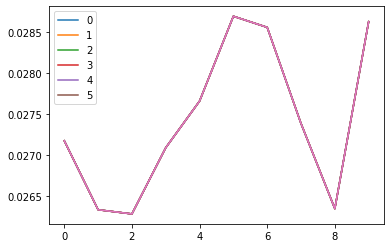

In [ ]:
for i in model.act_means: plt.plot(l[:10])
plt.legend(range(6))

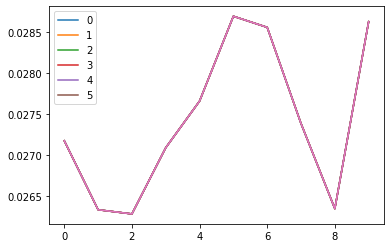

In [ ]:
for i in model.act_stds: plt.plot(l[:10])
plt.legend(range(6))

**Pytorch Hooks**

In [ ]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [ ]:
act_means = [[] for _ in model]
act_stds   = [[] for _ in model]

In [ ]:
def append_stats(i, mod, inp, outp):
  act_means[i].append(outp.data.mean())
  act_stds [i].append(outp.data.std())

In [ ]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [ ]:
run.fit(1, learn)

train: [2.27629515625, tensor(0.1772, device='cuda:0')]
valid: [1.742241015625, tensor(0.3368, device='cuda:0')]


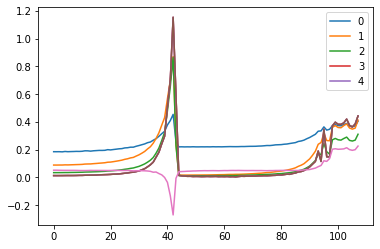

In [ ]:
for o in act_means: plt.plot(o)
plt.legend(range(5))

**HOOK CLASS**

In [ ]:
def children(m): return list(m.children())

class Hook():
  def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
  def remove(self): self.hook.remove()
  def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
  if not hasattr(hook,'stats'): hook.stats = ([],[])
  means, stds = hook.stats
  means.append(outp.data.mean())
  stds.append(outp.data.std())

In [ ]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [ ]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [ ]:
run.fit(1, learn)

In [ ]:
for h in hooks:
  plt.plot(h.stats[0])
  h.remove()
plt.legend(range(4))

**A Hook Class**

In [ ]:
#export
class ListContainer():
  def __init__(self, items): self.items= listify(items)
  def __getitem__(self, idx):
    if isinstance(idx, (int, slice)): return self.items[idx]
    if isinstance(idx[0], bool):
      assert len(idx)==len(self)
      return [o for m,o in zip(idx, self.items) if m]
    return[self.items[i] for i in idx]
  def __len__(self): return len(self.items)
  def __iter__(self): return iter(self.items)
  def __setitem__(self, i ,o):self.items[i] = o
  def __delitem__(self, i): del(self.items[i])
  def __repr__(self):
    res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
    if len(self)>10: res = res[:-1]+ ', ...]'
    return res


In [ ]:
ListContainer(range(10))

In [ ]:
ListContainer(range(100))

In [ ]:
t = ListContainer(range(10))
t[[1,2]], t[[False] * 8+ [True,False]]

In [ ]:
#export
from torch.nn import init

class Hooks(ListContainer):
  def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
  def __enter__(self, *args): return self
  def __exit__(self, *args): self.remove()
  def __del__(self): self.remove()

  def __delitem__(self, i):
    self[i].remove()
    super().__delitem__(i)

  def remove(self):
    for h in self: h.remove()

In [ ]:
model = get_cnn_model(data,nfs).cuda()
learn, run = get_runner(model, data, lr =0.5, cbs=cbfs)

In [ ]:
hooks = Hooks(model, append_stats)
hooks

In [ ]:
hooks.remove()

In [ ]:
x,y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [ ]:
x.mean(), x.std()

In [ ]:
p = model[0](x)
p.mean(),p.std()

In [ ]:
for i in model:
  if isinstance(l, nn.Sequential):
    init.kaiming_normal(l[0].weight)
    l[0].bias.data.zero_()

In [ ]:
p = model[0](x)
p.mean(), p.std()

In [ ]:
with Hooks(model, append_stats) as hooks:
  run.fit(2, learn)
  fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
  for h in hooks:
    ms,ss = h.stats
    ax0.plot(ms[:10])
    ax1.plot(ms[:10])
  plt.legend(range(6));

  fig,(ax0,ax1) = plt.subplots(1,2,figsize=(10,4))
  for h in hooks:
    ms,ss = h.stats
    ax0.plot(ms)
    ax1.plot(ss)
  plt.legend(range(6))

**Other Statistics**

In [ ]:
def append_stats(hook, mod,inp,outp):
  if not hasattr(hook,'stats'): hook.stats = ([],[],[])
  means,stds,hists=hook.stats
  means.append(outp.data.mean().cpu())
  stds.append(outp.data.std().cpu())
  hists.append(outp.data.cpu().histc(40,0,10))

In [ ]:
model = get_cnn_model(data,nfs).cuda()
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [ ]:
for l in model:
  if isinstance(l, nn.Sequential):
    init.kaiming_normal_(l[0].weight)
    l[0].bias.data.zero_()

In [ ]:
with Hooks(model, append_stats) as hooks: run.fit(1, learn)

In [ ]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

In [ ]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
  ax.imshow(get_hist(h), origin='lower')
  ax.axis('off')
plt.tight_layout()

In [ ]:
 def get_min(h):
   h1 = torch.stack(h.stats[2]).t().float()
   return h1[:2].sum(0)/h1.sum(0)

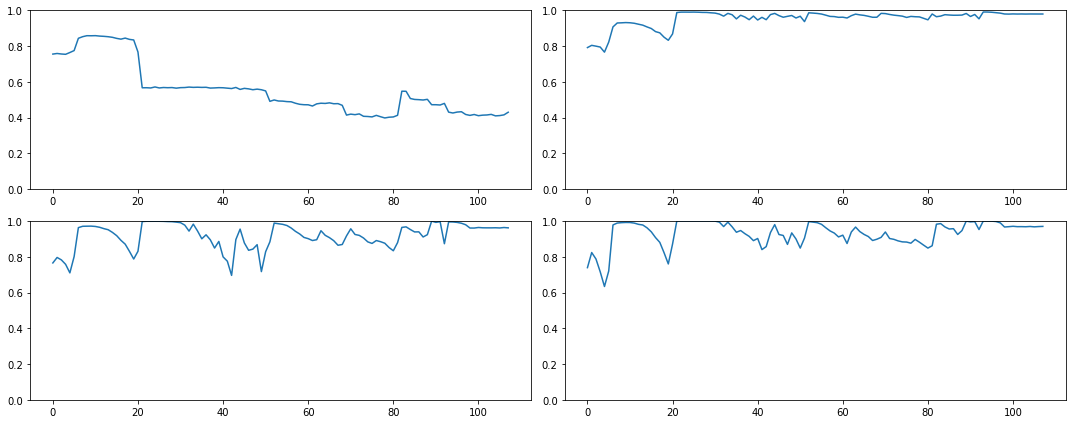

In [ ]:
fig,axes = plt.subplots(2,2,figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
  ax.plot(get_min(h))
  ax.set_ylim(0,1)
plt.tight_layout()

**Generalized ReLU**

In [ ]:
#export
def get_cnn_layers(data, nfs, layer, **kwargs):
  nfs = [1] + nfs
  return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
          for i in range(len(nfs)-1)] + [
  nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
  return nn.Sequential(
      nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))
  
class GeneralRelu(nn.Module):
  def __init__(self, leak=None, sub=None, maxv=None):
    super().__init__()
    self.leak,self.sub,self.maxv = leak,sub,maxv

  def forward(self, x):
    x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
    if self.sub is not None: x.sub_(self.sub)
    if self.maxv is not None: x.clamp_max_(self.maxv)
    return x

def init_cnn(m, uniform=False):
  f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
  for l in m:
    if isinstance(l, nn.Sequential):
      f(l[0].weight, a=0.1)
      l[0].bias.data.zero_()

def get_cnn_model(data, nfs, layer, **kwargs):
  return nn.Sequential(*get_cnn_layers(data, nfs,layer,**kwargs))

In [ ]:
def append_stats(hook, mod, inp, outp):
  if not hasattr(hook,'stats'): hook.stats = ([],[],[])
  means,stds,hists = hook.stats
  means.append(outp.data.mean().cpu())
  stds. append(outp.data.std().cpu())
  hists.append(outp.data.cpu().histc(40,-7,7))

In [ ]:
model = get_cnn_model(data,nfs,conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.47017734375, tensor(0.8518, device='cuda:0')]
valid: [0.14670611572265624, tensor(0.9578, device='cuda:0')]


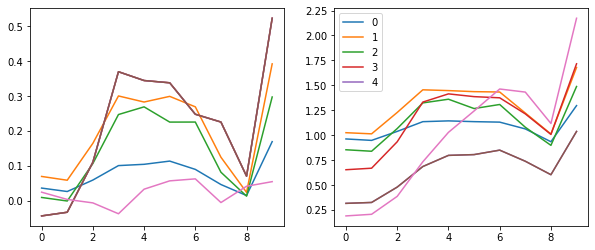

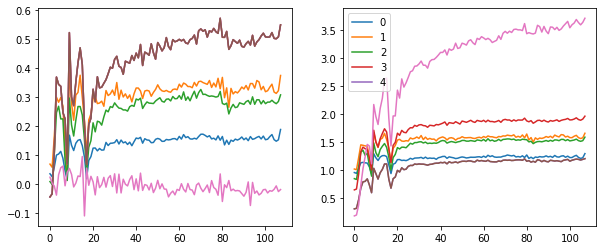

In [ ]:
with Hooks(model, append_stats) as hooks:
  run.fit(1,learn)
  fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
  for h in hooks:
    ms,ss,hi = h.stats
    ax0.plot(ms[:10])
    ax1.plot(ss[:10])
    h.remove()
  plt.legend(range(5))

  fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
  for h in hooks:
    ms,ss,hi = h.stats
    ax0.plot(ms)
    ax1.plot(ss)
    h.remove()
  plt.legend(range(5))

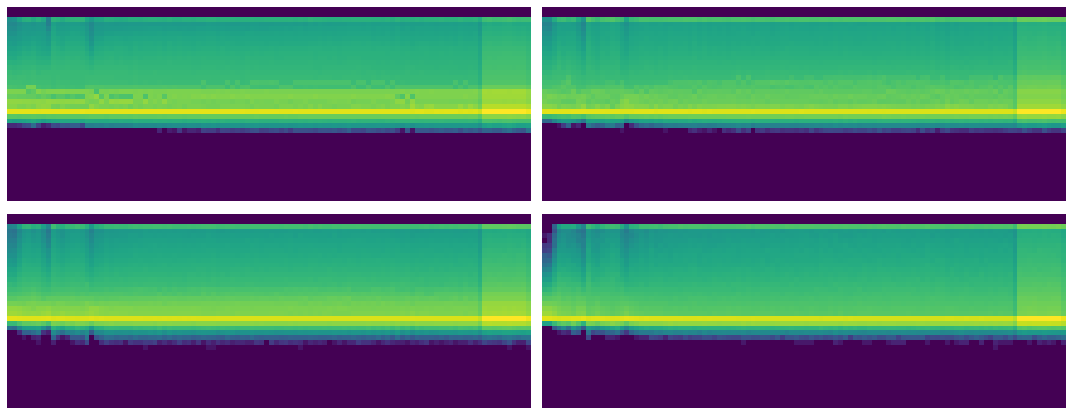

In [ ]:
fig,axes = plt.subplots(2,2,figsize=(15,6))
for ax,h in zip(axes.flatten(),hooks[:4]):
  ax.imshow(get_hist(h), origin="lower")
  ax.axis('off')
plt.tight_layout() 

In [ ]:
def get_min(h):
  h1 = torch.stack(h.stats[2]).t().float()
  return h1[19:22].sum(0)/h1.sum(0)

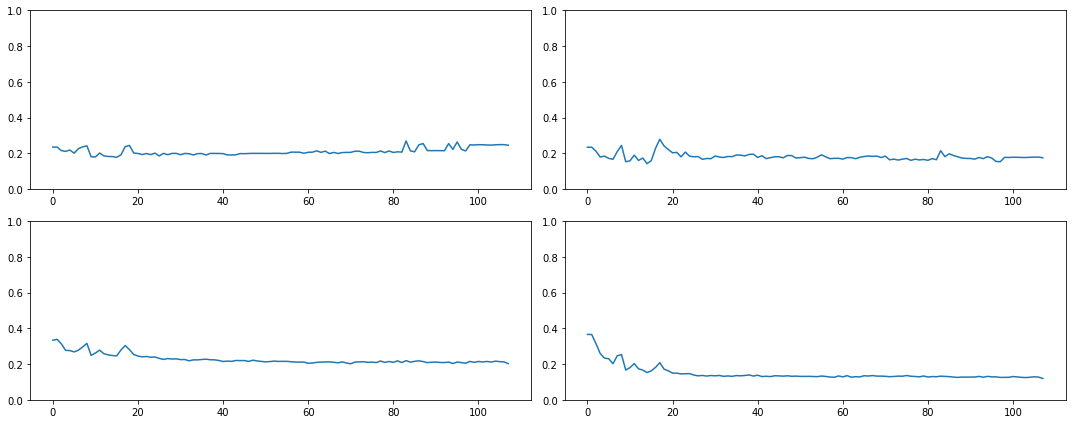

In [ ]:
fig,axes = plt.subplots(2,2,figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
  ax.plot(get_min(h))
  ax.set_ylim(0,1)
plt.tight_layout()

In [ ]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None,opt_func=None, uniform=False, **kwargs):
  model = get_cnn_model(data, nfs, layer, **kwargs)
  init_cnn(model, uniform=uniform)
  return get_runner(model, data,lr=lr,cbs=cbs, opt_func=opt_func)

In [ ]:
'''class ParamScheduler(Callback):
  _order = 1
  def __init__(self, pname, sched_func): 
    self.pname = pname 
    self.sched_func = sched_func

  def set_param(self):
    for pg in self.opt.param_groups:
      pg[self.pname] = self.shed_func(self.n_epochs/self.epochs)

  def begin_batch(self):
    if self.in_train: self.set_param()'''

'class ParamScheduler(Callback):\n  _order = 1\n  def __init__(self, pname, sched_func): \n    self.pname = pname \n    self.sched_func = sched_func\n\n  def set_param(self):\n    for pg in self.opt.param_groups:\n      pg[self.pname] = self.shed_func(self.n_epochs/self.epochs)\n\n  def begin_batch(self):\n    if self.in_train: self.set_param()'

In [ ]:
sched = combine_scheds([0.5,0.5], [sched_cos(0.2,1.), sched_cos(1.,0.1)])

In [ ]:
sched

<function nb_05.combine_scheds.<locals>._inner>

In [ ]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler,'lr',sched)])

In [ ]:
#run.fit(8,learn)

In [ ]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, uniform=True,
                            cbs=cbfs+[partial(ParamScheduler,'lr',sched)])
 
learn, run = get_learn_run(nfs, data, 1., conv_layer, uniform=True,
                            cbs=cbfs)

In [ ]:
run.fit(8, learn)

train: [2.0574365625, tensor(0.2850, device='cuda:0')]
valid: [1.14277451171875, tensor(0.6288, device='cuda:0')]
train: [2.0574365625, tensor(0.2850, device='cuda:0')]
valid: [1.1587887276785713, tensor(0.6263, device='cuda:0')]
train: [2.0574365625, tensor(0.2850, device='cuda:0')]
valid: [1.1600205528846155, tensor(0.6261, device='cuda:0')]
train: [2.0574365625, tensor(0.2850, device='cuda:0')]
valid: [1.1604740131578948, tensor(0.6260, device='cuda:0')]
train: [2.0574365625, tensor(0.2850, device='cuda:0')]
valid: [1.160709875, tensor(0.6260, device='cuda:0')]
train: [2.0574365625, tensor(0.2850, device='cuda:0')]
valid: [1.160854737903226, tensor(0.6260, device='cuda:0')]
train: [2.0574365625, tensor(0.2850, device='cuda:0')]
valid: [1.160952787162162, tensor(0.6260, device='cuda:0')]
train: [2.0574365625, tensor(0.2850, device='cuda:0')]
valid: [1.1610232558139535, tensor(0.6260, device='cuda:0')]


In [ ]:
!pip install fire

In [ ]:
!python notebook2script.py 06_cuda_cnn_hooks_init.ipynb